#Week 3 Part 1: CNN Architectures

Tutorial by Cher Bass
(edited by Emma Robinson)

Let's start by importing the modules and Data that we need for the notebook. We start by testing on the MNIST dataset as before.  

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F #contains some useful functions like activation functions & convolution operations you can use

import torchvision
import numpy as np
from torchvision import datasets, models, transforms

# This is used to transform the images to Tensor and normalize it
transform = transforms.Compose(
   [transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])])

training = torchvision.datasets.MNIST(root='./data', train=True,
                                       download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(training, batch_size=32,
                                         shuffle=True, num_workers=2)

testing = torchvision.datasets.MNIST(root='./data', train=False,
                                      download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testing, batch_size=32,
                                        shuffle=False, num_workers=2)

classes = ('0', '1', '2', '3',
          '4', '5', '6', '7', '8', '9')


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



**To DO** Now set your device to cuda (if you have access to a GPU) or cpu otherwise 

**hint** see lecture 2

In [2]:
#STUDENTS TO DO 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
print(device) 

cuda


## ResNet with pytorch

ResNet was first introduced in 2015 as a way to support training of deeper networks through supporting networks in learning identity mappings during training. It does this through implementation of residual blocks

An example of a resnet block (from the original [2015 paper](https://arxiv.org/abs/1512.03385)) is illustrated below (see [image source](t)):

<figure>
<img src="https://drive.google.com/uc?id=1NQ_sLsu0GsXQsVEQ9Rtm5Mnvm2BuucCZ" alt="Drawing" style="width: 800px;"/>
<figcaption align = "centre"> Fig 1. ResNet 2015 residual block  </figcaption>
</figure>

Here, input data passes down two paths. In one, it is passed through two convolutional (weights learning) layers; in the other it skips these out to be added to the output of these layers. This shortcut operation is the identity mapping. If there are no gains to be made by learning more weights kernels (the nework is already deep enough); then the network can simply learn to pass the input unchanged through the block (an idenity transform) by pushing these weights kernels to zero.

### Using PyTorch implementation

Torchvision offers some default implementations of popular networks

For example the following pretrained resnets models can be loaded in Pytorch:
```python
import torchvision
torchvision.models.resnet18(pretrained=True, **kwargs)
```

You can also load a model that hasn't been pretrained in the following way:
```python
torchvision.models.resnet18(pretrained=False, **kwargs)
```

To see more examples, including networks such as ResNet, Alexnet, VGG, Densenet, see [torchvision models](https://pytorch.org/docs/stable/torchvision/models.html) and, for usage, see the official [tutorial](https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html)

However, these pretrained models will not always suit your needs. For example, the resnet models are designed for 3 channel input  (i.e. for RGB natural channels); this means that you can't use them without adjustment on grayscale images, or on 3D medical data.


## **Exercise 1 Programming your own ResNet**

### **Coding the residual block**

The first thing we need to do is implement a `BasicBlock` class, which will implement a single ResNet (2015) block, which includes the following steps (see Fig 1): 

1. **(strided) Convolution, followed by batchnorm**, followed by relu: with option to downsample through stride=2 and increase the number of output channels
2. **Convolution, followed by batchnorm:** stride 1; input and output channels constant
3. **shortcut step**, where the input is first transformed through a strided $1 \times 1$ convolutional operation to match the dimensions of the output of the residual block and then added to the output of the convolutions. 
4. **relu**

Note, **only the first convolution of each block offers the option of upsampling the channel dimension and downsampling the data through striding**. Further, several residual blocks are typically changed together between downsampling steps (see lilac, green and red groups); therefore downsampling is not implemented for all blocks.

<img src="https://drive.google.com/uc?id=1SVmOrg7uxRowWQNtr5jWmz2re9fLID4Q" alt="Drawing" style="width: 800px;"/>

### **Ex 1.1 - Create the Residual  block**

The most challenging bit of coding up a residual block is implementing the reshapeing of the shortcut step. So let's start by ignoring it to create the main body of the residual block. This will work **_provided we maintain input dimensions_**. 

Let us create a `ResidualBlock` and define (parametrise) the required `Conv2d` and `BatchNorm2d` steps in the constructor `__init__(self, channels1,channels2,res_stride=1)`; here `res_stride` is the intended stride, `channels1` are the number of channels of the incoming activations, and `channels2` is the number of output channels. Note, `res_stride`=1 by default and this should only change if this is intended as a downsampling block;

Note, biases are set to `False` in the block as they are instead handled by the batchnorm layer [see](https://discuss.pytorch.org/t/why-does-the-resnet-model-given-by-pytorch-omit-biases-from-the-convolutional-layer/10990/2). Also, observe that the Relu layer is implemented in the forward pass function.

**To do 1.1 A** Tasks: Edit (`__init__`) to input

1. `self.conv1` a 2D convolution with the power to: a) downsample spatial dimensions (with stride `res_stride` ); and b) upsample channel dimensions (to `channels2`). Set arguments `kernel_size=3, stride=res_stride, padding=1, bias=False`
2. ` self.bn1` a 2D batchnorm layer to follow the first convolutional layer. What does it expect for the number of input features (`num_features`)?
3. `self.conv2` the second convolutional layer. What should its stride, input and output channel dimensions be given **only the first convolution can change output dimensions**? (set `kernel_size=3, padding=1, bias=False` as before)
4. ` self.bn2` a 2D batchnorm layer to follow the second convolutional layer. **Note, a different batch normalisation instance is needed each time as each stores learnable parameters**.

For PyTorch documentation, see [nn.Conv2d](https://pytorch.org/docs/stable/nn.html#torch.nn.Conv2d) and [nn.BatchNorm2d](https://pytorch.org/docs/stable/nn.html#torch.nn.BatchNorm2d)

**To do 1.1 B** Edit `forward(self, x)` line 35 to **implement the shortcut**. Here the identity mapping `self.shortcut(x)` must be _added_ to the output of the weights layers. 

Here, the operations of the identity mapping `self.shortcut(x)`  depends on whether this is a downsampling block or not. In this first instance, we assume `res_stride` $= 1$ and thus the shape of the output tensor is the same as the input tensor. Thus  `self.shortcut=nn.Sequential()`, an empty sequential block which outputs the identity mapping `self.shortcut(x)=x`.

**Make sure you understand what all lines of the forward function are doing**. Note, that at line 29 the output of the first operation is assigned to variable `out` in order to preserve the input `x` for the shortcut (identity) mapping.







In [3]:
class ResidualBlock(nn.Module):

    def __init__(self, channels1,channels2,res_stride=1):
        super(ResidualBlock, self).__init__()
        self.inplanes=channels1
        # Exercise 1.1 construct the block (without shortcut -> Ex 1.3)
        # implement conv1 (which option for reshaping), batchnorm and conv2 (no reshaping)
        self.conv1=nn.Conv2d(channels1,channels2,kernel_size=3,stride=res_stride,padding=1, bias=False)
        self.bn1=nn.BatchNorm2d(channels2)
        self.conv2=nn.Conv2d(channels2,channels2,kernel_size=3,stride=1,padding=1, bias=False)
        self.bn2=nn.BatchNorm2d(channels2)

        if res_stride != 1 or channels2 != channels1:
            # Exercise 1.3 the shortcut (supports resizing input during identity mapping)
            # create an nn.Sequential block with one 1x1 conv2D and one batchnorm
            # using res_stride to change spatial dimensions and channel 2 to change channel dimensions
            # again bias must be set to False
            self.shortcut=nn.Sequential(nn.Conv2d(channels1,channels2,kernel_size=1,stride=res_stride, bias=False),
                                        nn.BatchNorm2d(channels2))
            
        else:
            self.shortcut=nn.Sequential()
            

    def forward(self, x):
        
        # forward pass: Conv2d > BatchNorm2d > ReLU > Conv2D >  BatchNorm2d > ADD > ReLU
        out=self.conv1(x)
        out=self.bn1(out)
        out = F.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        # Exercise 1.1B STUDENT TO Do - IMPLEMENT THE shortcut (1 line)
        out+=self.shortcut(x)

        # final ReLu
        out = F.relu(out)


        return out





### **Ex 1.2 . Perform a test forward pass ( <font color="red"> _keeping input and output dimensions constant_ </font> )**

1. Instantiate an instance of class ResidualBlock (create a network called `blk`) with input chananels = 3 and output channels=3; leave `res_stride` as default (1). **We have not implemented a shortcut with downsampling yet** so running with stride will fail
2. create a random tensor of size $5 \times 3 \times 100 \times 100$ (which matches expected input dimensions $N,C_{in},H,W$ the expected input channel dimensions of 3
3. Pass the input through a forward pass and print input and output shape.

**hint** look at how this was done in previous training loops. Remember - you don't need to explicitely call the forward function.

In [4]:
##  Student To do 
blk=ResidualBlock(3,3,1)
data=torch.rand((5,3,100,100))
output=blk(data)
print(data.shape, output.shape)

torch.Size([5, 3, 100, 100]) torch.Size([5, 3, 100, 100])


### **Ex 1.3. Implement the shortcut**

Next, let's go back and implement a shortcut with downsampling. 

Specfically, **if this is a reshaping residual block** (`channels2` $\ne$ `channels1` and `res_stride` $\neq$ 1) then **we will also need to reshape the input as it is passed through the shortcut**. This is the objective of this task.

**To do:** Go back and edit the `ResidualBlock` constructor to complete the shortcut function, which will downsample the input as it is passed through the shortcut. 

**Change line 14 in `ResidualBlock.__init__()` to implement a nn.Sequential block with two steps**:
1. A $1 \times 1 $ `nn.Conv2d` layer with `stride=res_stride,bias=False`.  This will support changes of spatial dimensions through strided convolutions and changes of feature dimensions through $1 \times 1 $ convolutions. What should your input and output channels be to make it equivalent to the output of a _reshaping_ residual block?
2. batch normalisation. Think carefully about the input dimension. 

**To Do** Once you have done this, test the network again, but this time **implmnent stride of 2 and change the number of output channels**
 

In [5]:
# STUDENTS TO DO
# forwards pass with stride 2; change channels from 3 to 10
##  Student To do 
blk2=ResidualBlock(3,3,2)
output=blk2(data)
print(data.shape, output.shape)

torch.Size([5, 3, 100, 100]) torch.Size([5, 3, 50, 50])


We are now have all the building blocks we need to build a residual network. In what follows we will construct a ResNet with four residual layers. Each layer will contain 2 residual blocks. 

### **Ex 1.4 : Create a Residual Network class**

In the original paper the network starts with a  convolutional layer with a $7 \times 7 $ kernel, followed by a batchnorm. However, as we intend to test on the MNIST (which is very small) lets change the $7 \times 7 $ kernel to a $3 \times 3 $. We will implement 4 residual layers (or blocks), where the residual block class is passed to the network class as the argument `block`, and output channels and strides for each block are parametrised by lists (also past to the constructor) as `num_features` and `num_strides` respectively.

**Step 1 To do 1.4 A** 
- Initialise the network with a 3 x3 convolutional layer, with input channels = `in_channels`, output channel = `num_features[0]`,  stride = `num_strides[0]`, padding=1 and bias false; 
- implement a batch normalisation layer to follow this.

**Step 2 To Do 1.4 B** 

- Comment the function `_make_layer`. What is each line doing? 
- make sure you understand how this is used to create residual blocks in the constructor 

**Step 4 To Do 1.4 C** 

- The penultimate layer of the network is an average pool (line 40) which averages over spatial dimensions to return a flattened vector of length equal to the number of channels of the tensor passed to it. 
- the network must output 10 class predictions
- Bearing that in mind implement the final linear layer of the network 

**hint** if you remain unsure you can always print the shape of all the tensors in the network

In [6]:
class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_strides, num_features, in_channels, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = num_features[0] # in_planes stores the number channels output from first convolution
        #STUDENT TO DO 1.4A replace None (2 lines)
        # step 1. Initialise the network with a 3 x3 conv and batch norm
        self.conv1=nn.Conv2d(in_channels,num_features[0],kernel_size=3,stride=num_strides[0],padding=1,bias=False)
        self.bn1=nn.BatchNorm2d(num_features[0])
        # Step 2: TO DO Using function make_layer() create 4 residual layers
        # num_blocks per layer is given by input argument num_blocks (which is an array)
        self.layer1 = self._make_layer(block, num_features[1], num_blocks, stride=num_strides[1])
        self.layer2 = self._make_layer(block, num_features[2], num_blocks, stride=num_strides[2])
        self.layer3 = self._make_layer(block, num_features[3], num_blocks, stride=num_strides[3])
        self.layer4 = self._make_layer(block, num_features[4], num_blocks, stride=num_strides[4])
        #STUDENT TO DO 1.4 C create Linear layer
        self.linear = nn.Linear(num_features[4],num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        layers = []
        #STUDENT TO DO 1.4B -comment
        # add downsampling residual block
        layers.append(block(self.in_planes, planes, stride))

        for i in np.arange(num_blocks-1):
            # add remaining residual blocks
            layers.append(block(planes, planes))
        
        
        self.in_planes = planes 
              
        return nn.Sequential(*layers)

    def forward(self, x):
      # initial convolution and batch norm
        out = F.relu(self.bn1(self.conv1(x)))
        #residual blocks 
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        
        #average pool (flattens spatial dimensions)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)       
        out = self.linear(out)

        return out
    

### **1.5:  Train on MNIST for classification**

Below we have created an instance of our resent class which runs four levels of residual blocks, with 2 blocks in each group

**To do** 
- create a suitable loss function for classification
- create an SGD optimiser with momentum, assign learning rate as 0.001
- complete the training function - **don't forget to set runtime to GPU and to push input data and labels (from each batch) to the device**
- test performance of your network by running the validation code in the cells below





In [ ]:
#-----------------------------------------------------task 4 -----------------------------------------------------
# Task 4: Train and test ResNet on MNIST dataset for classification
# hints: define your resnet network, loss function, optimizer and dataloaders. 
# Then you can run the same training and testing code as above.
# ----------------------------------------------------------------------------------------------------------------

In [7]:
import torch.optim as optim

# 
resnet = ResNet(ResidualBlock,3, [1,1,2,2,2], [64,64,128,256,512], in_channels=1)
# see how the network is loaded to the device (cpu or GPU)
# this allows the optimisation to be run on GPU
resnet = resnet.to(device) 
# Ex 1.5 create suitable loss function
loss_fun = nn.CrossEntropyLoss()
# Ex 1.5 create SGD optimiser with. momentunm
optimizer = optim.Adam(resnet.parameters(), lr=0.001)

In [8]:
epochs = 1
for epoch in range(epochs): 
    #resnet.train()
    # enumerate can be used to output iteration index i, as well as the data 
    for i, (data, labels) in enumerate(train_loader, 0):
        # STUDENTS TO DO 1.5 complete training loop
        data = data.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        output=resnet(data)

        loss=loss_fun(output,labels)

        loss.backward()

        optimizer.step()
        
        # print statistics of loss tensor
        ce_loss = loss.item()
        if i % 10 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, ce_loss))


[1,     1] loss: 2.567
[1,    11] loss: 1.099
[1,    21] loss: 0.941
[1,    31] loss: 0.514
[1,    41] loss: 0.479
[1,    51] loss: 0.694
[1,    61] loss: 0.287
[1,    71] loss: 0.248
[1,    81] loss: 0.355
[1,    91] loss: 0.306
[1,   101] loss: 0.213
[1,   111] loss: 0.322
[1,   121] loss: 0.079
[1,   131] loss: 0.089
[1,   141] loss: 0.087
[1,   151] loss: 0.503
[1,   161] loss: 0.162
[1,   171] loss: 0.073
[1,   181] loss: 0.082
[1,   191] loss: 0.237
[1,   201] loss: 0.429
[1,   211] loss: 0.322
[1,   221] loss: 0.343
[1,   231] loss: 0.100
[1,   241] loss: 0.199
[1,   251] loss: 0.023
[1,   261] loss: 0.068
[1,   271] loss: 0.220
[1,   281] loss: 0.158
[1,   291] loss: 0.059
[1,   301] loss: 0.008
[1,   311] loss: 0.272
[1,   321] loss: 0.037
[1,   331] loss: 0.032
[1,   341] loss: 0.034
[1,   351] loss: 0.218
[1,   361] loss: 0.218
[1,   371] loss: 0.330
[1,   381] loss: 0.062
[1,   391] loss: 0.093
[1,   401] loss: 0.040
[1,   411] loss: 0.027
[1,   421] loss: 0.071
[1,   431] 

Predicted:      7     2     1     0     4     1     4     9


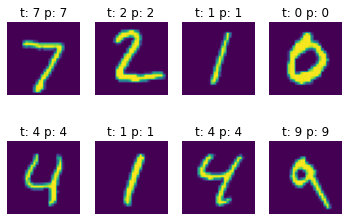

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
#make an iterator from test_loader
#Get a batch of testing images
test_iterator = iter(test_loader)
images, labels = test_iterator.next()

images = images.to(device)
labels = labels.to(device)

y_score = resnet(images)
# get predicted class from the class probabilities
_, y_pred = torch.max(y_score, 1)

print('Predicted: ', ' '.join('%5s' % classes[y_pred[j]] for j in range(8)))
rows = 2
columns = 4
# plot y_score - true label (t) vs predicted label (p)
fig2 = plt.figure()
for i in range(8):
    fig2.add_subplot(rows, columns, i+1)
    plt.title('t: ' + classes[labels[i].cpu()] + ' p: ' + classes[y_pred[i].cpu()])
    img = images[i] / 2 + 0.5     # this is to unnormalize the image
    img = torchvision.transforms.ToPILImage()(img.cpu())
    plt.axis('off')
    plt.imshow(img)
plt.show()


In [10]:
y_true = labels.data.cpu().numpy()
y_pred = y_pred.data.cpu().numpy()

In [11]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
print('accuracy:', accuracy, ', f1 score:', f1, ', precision:', precision, ', recall:', recall)

accuracy: 1.0 , f1 score: 1.0 , precision: 1.0 , recall: 1.0


## **(optional) Exercise 2 - Use ResNet for classification - CIFAR10**

Use the torch inbuilt ResNet for RBG images and train for classification on the CIFAR10 dataset.

Here are some example images (from [source]( https://appliedmachinelearning.blog/2018/03/24/achieving-90-accuracy-in-object-recognition-task-on-cifar-10-dataset-with-keras-convolutional-neural-networks/)) from the CIFAR10 datasets - we have 10 classes:

<img src="https://drive.google.com/uc?id=1C_rcRMzjw3V-nnv18WDoHKuvTxKPhLwn" alt="Drawing" style="width: 800px;"/>

You can load the CIFAR10 dataset using torchvision in the following way:
```python
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
```
You can use [this tutorial]( https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html) as a reference for training on CIFAR10 -

Remember to define your loss function, optimizer, dataloaders, and your resnet network. 
Then run the training and testing, same as with MNIST.

**To do 2.1 ** First, run the below cell to import the PyTorch ResNet; push it to the device (for GPU training)


In [15]:
from torchvision import models

resnet_cifar = models.resnet18(pretrained=True)
resnet_cifar = resnet_cifar.to(device) # note how network is passed to device for GPU training

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
#-----------------------------------------------------task 5 -----------------------------------------------------
# Task 5: Train and test ResNet on CIFAR10 dataset for classification
# hints: define your resnet network, loss function, optimizer and dataloaders. 
# Then you can run the same training and testing code as above.
# ----------------------------------------------------------------------------------------------------------------

**TO Do: 2.2** Train and test ResNet on CIFAR10 dataset for classification
- create a train and test dataset using torchvision.datasets.CIFAR (completed for you)
- create separate dataloader for test and train with `batch_size=8`; as usual, set `shuffle=True` for trains and `shuffle=False` for test
- define a loss function for classification
- set optimizer to SGD with momentum, learning rate=0.001
- implement training loop; train on GPU

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=8,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(testset, batch_size=8,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [17]:
import torch.optim as optim

loss_fun = nn.CrossEntropyLoss()
loss_fun = loss_fun.to(device)

optimizer = optim.SGD(resnet_cifar.parameters(), lr=0.001, momentum=0.9)

In [18]:
epochs = 1
for epoch in range(epochs): 

    # enumerate can be used to output iteration index i, as well as the data 
    for i, (data, labels) in enumerate(train_loader, 0):
        data = data.to(device)
        labels = labels.to(device)
        # clear the gradient
        optimizer.zero_grad()

        #feed the input and acquire the output from network
        outputs = resnet_cifar(data)

        #calculating the predicted and the expected loss
        loss = loss_fun(outputs, labels)

        #compute the gradient
        loss.backward()

        #update the parameters
        optimizer.step()

        # print statistics
        ce_loss = loss.item()
        if i % 10 == 0:
            print('[%d, %5d] loss: %.3f' %
                 (epoch + 1, i + 1, ce_loss))


[1,     1] loss: 11.084
[1,    11] loss: 8.120
[1,    21] loss: 7.842
[1,    31] loss: 6.919
[1,    41] loss: 4.150
[1,    51] loss: 2.659
[1,    61] loss: 3.999
[1,    71] loss: 2.697
[1,    81] loss: 2.380
[1,    91] loss: 2.565
[1,   101] loss: 2.275
[1,   111] loss: 2.494
[1,   121] loss: 3.549
[1,   131] loss: 2.087
[1,   141] loss: 2.556
[1,   151] loss: 2.175
[1,   161] loss: 1.975
[1,   171] loss: 1.621
[1,   181] loss: 1.705
[1,   191] loss: 1.871
[1,   201] loss: 2.383
[1,   211] loss: 1.727
[1,   221] loss: 1.972
[1,   231] loss: 2.131
[1,   241] loss: 2.587
[1,   251] loss: 2.331
[1,   261] loss: 2.570
[1,   271] loss: 2.190
[1,   281] loss: 2.805
[1,   291] loss: 2.224
[1,   301] loss: 2.345
[1,   311] loss: 2.021
[1,   321] loss: 2.140
[1,   331] loss: 1.917
[1,   341] loss: 2.309
[1,   351] loss: 2.091
[1,   361] loss: 2.241
[1,   371] loss: 1.485
[1,   381] loss: 2.308
[1,   391] loss: 2.366
[1,   401] loss: 2.020
[1,   411] loss: 2.137
[1,   421] loss: 2.146
[1,   431]

Predicted:    dog truck truck plane   dog  frog  deer  deer


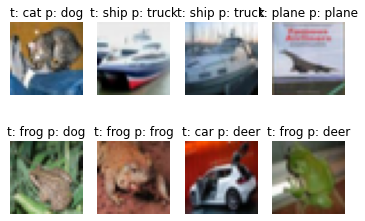

In [19]:
#make an iterator from test_loader
#Get a batch of testing images
test_iterator = iter(test_loader)
images, labels = test_iterator.next()
images = images.to(device)
labels = labels.to(device)

y_score = resnet_cifar(images)
# get predicted class from the class probabilities
_, y_pred = torch.max(y_score, 1)

print('Predicted: ', ' '.join('%5s' % classes[y_pred[j]] for j in range(8)))
rows = 2
columns = 4
# plot y_score - true label (t) vs predicted label (p)
fig2 = plt.figure()
for i in range(8):
    fig2.add_subplot(rows, columns, i+1)
    plt.title('t: ' + classes[labels[i].cpu()] + ' p: ' + classes[y_pred[i].cpu()])
    img = images[i] / 2 + 0.5     # this is to unnormalize the image
    img = torchvision.transforms.ToPILImage()(img.cpu())
    plt.axis('off')
    plt.imshow(img)
plt.show()


In [20]:
y_true = labels.data.cpu().numpy()
y_pred = y_pred.data.cpu().numpy()

In [21]:
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score

accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
print('accuracy:', accuracy, ', f1 score:', f1, ', precision:', precision, ', recall:', recall)

accuracy: 0.25 , f1 score: 0.1875 , precision: 0.25 , recall: 0.16666666666666666


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## **Exercise 3 Image segmentation with pytorch using U-net**

U-net was first developed in 2015 by [Ronneberger et al.](https://arxiv.org/abs/1505.04597), as a segmentation network for biomedical image analysis.
It has been extremely successful, with 9,000+ citations, and many new methods that have used the U-net architecture since.


The architecture of U-net is based on the idea of using skip connections (i.e. concatenating) at different levels of the network to retain high, and low level features.

Here is the architecture of a U-net:


<img src="https://drive.google.com/uc?id=1zUKKrbcB1BZxJ7-hEYpteCVlVFRJ1nRg" alt="Drawing" style="width: 800px;"/>



### Two-photon microscopy dataset of cortical axons

In this tutorial we use a dataset of cortical neurons with their corresponding segmentation binary labels.

These images were collected using in-vivo two-photon microscopy from the mouse somatosensory cortex. To generate the 2D images, a max projection was used over the 3D stack. The labels are binary segmentation maps of the axons.

Here we will use 100 [64x64] crops during training and validation. 

These are some example images [256x256] from the original dataset, taken from [Bass et al 2019](http://proceedings.mlr.press/v102/bass19a.html)

<img src="https://drive.google.com/uc?id=1YRJev88nBr4aqyaHRU27KWxFaX4JwUJz" alt="Drawing" style="width: 800px;"/>


**To DO Ex 3.1** 
- this dataset is too large for Keats so you must access the data from this [Google Drive link](https://drive.google.com/drive/folders/1R5Myca6egnuqLXrDqj6pbw9ei9ufRlDj?usp=sharing). 
- Once you access the link the folder should be accessible from your Google Drive, you may then need to edit the line 2 of cell 31 to reference the path **relative to your own Drive** and **make sure to save outputs to your own Drive** (note if this is proving difficult you can download the folder and upload it to your own drive)
- run the below lines of code to mount the drive and the dataset



In [22]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
# edit this link to correspond to the location of the shred folder on your google drive 
%cd '/content/drive/My Drive/Colab Notebooks/Colab_Data/week3-Data/'

# # List files to make sure we're in the expected directory.
# # Your output will look different, showing your own Drive files here.
!ls

#load modules
from __future__ import print_function
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch
from torch.autograd import Variable
from AxonDataset import AxonDataset
import torch.nn as nn
from torch.utils.data.sampler import SubsetRandomSampler
import time
import torch.nn.functional as F
import torchvision.utils as vutils
import os
import matplotlib.pyplot as plt



/content/drive/My Drive/Colab Notebooks/Colab_Data/week3-Data
3_2_Architectures_colab.ipynb  data	 __pycache__
AxonDataset.py		       npy_data  results


In [24]:
# Setting parameters
timestr = time.strftime("%d%m%Y-%H%M")
__location__ = os.path.realpath(
    os.path.join(os.getcwd(), os.path.dirname('__file__')))

print(__location__)
path = os.path.join(__location__,'results')
if not os.path.exists(path):
    os.makedirs(path)
    
# Define your batch_size
batch_size = 16
print(path)

/content/drive/MyDrive/Colab Notebooks/Colab_Data/week3-Data
/content/drive/MyDrive/Colab Notebooks/Colab_Data/week3-Data/results


### **Ex 3.2 Creating a dataloader**

In this example, a custom dataset was created, and we import it from `AxonDataset.py`. 

Then rather than create a separate test and train instance, we override the default DataLoader `shuffle` option to instead implement a  `torch.utils.data.sampler.SubsetRandomSampler` to 'samples elements randomly from a given list of indices, without replacement' (see [PyTorch documentation](https://pytorch.org/docs/stable/data.html#torch.utils.data.SubsetRandomSampler)).

To do this:

1. data is randomly split into 80% train and 20% validation sets
2. these lists are passed to class `SubsetRandomSampler` to create a sampling instance for each group
3. train and validation DataLoaders are created from the same dataset by passing a different sampler for each class

This is a good way of randomly separating your own data, in instances where PyTorch does not provide custom Datasets

**To Do**
- Comment the lines of code to verify you understand how the bespoke samplers are implemented

In [26]:
# STUDENTS to comment code lines
#First we create a custom dataset of two photon microscopy images of axons
axon_dataset = AxonDataset(data_name='org64', type='train')

# We need to further split our training dataset into training and validation sets.
# Determine the number of examples in train and validation and create list of all indices
indices = list(range(len(axon_dataset)))  
# define the split size
split = int(len(indices)*0.2)  

# Get random list of indices for validation
validation_idx = np.random.choice(indices, size=split, replace=False)
# training examples are remainder 
train_idx = list(set(indices) - set(validation_idx))

# feed indices into the SubsetRandomSampler to create a sampling instance for each of train and validation
train_sampler = SubsetRandomSampler(train_idx)
validation_sampler = SubsetRandomSampler(validation_idx)

# Create a dataloader instance overriding shuffle to pass the bespoke samplers
train_loader = torch.utils.data.DataLoader(axon_dataset, batch_size = batch_size,
                                           sampler=train_sampler) 
val_loader = torch.utils.data.DataLoader(axon_dataset, batch_size = batch_size,
                                        sampler=validation_sampler) 


## **Building a U-net**

We next build our u-net network.

First we define a layer `double_conv` that performs 2 sets of convolution followed by ReLu.This is set up as a `nn.Sequential(` block.

In [27]:
# define U-net
def double_conv(in_channels, out_channels, padding=1):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding),
        nn.ReLU(inplace=True)
    )


The original U-net encoder performs downsampling through a $2 \times 2 $ max pool (however, strided convolutions are equally viable). Thus, in what follows, a single level of encoding can be represented as:

```
 conv1 = self.dconv_down1(x)
 conv1 = self.dropout(conv1)
 x = self.maxpool(conv1)
 ```
Here, a dropout layer is inserted between the convolutional layer and the maxpool for regularisation. An alternative approach is to insert a batchnorm between the `nn.Conv2d` and the `nn.ReLU` e.g. [see](https://github.com/milesial/Pytorch-UNet)

Next we need to define how we perform an upsample step. This  is performed through use of [`nn.Upsample`](https://pytorch.org/docs/stable/nn.html#torch.nn.Upsample), which interpolates the data to a higher resolution grid. The layer must be created in the consructor (see line 14)  and expects arguments `scale_factor` and (interpolation) `mode`. There are several options for the interpolation mode; we recommend bilinear. In this example we upsample by a `scale_factor` of 2 each time (to match the $2\times 2$ max pool used during downsampling). 
        
Then, a single level of decoding might may represented as:

```
 deconv4 = self.upsample(conv5)
 deconv4  = self.dconv_up4(deconv4)
 deconv4 = self.dropout(deconv4)
 ```
 
However, we are still missing something vital...

### **Skip connections**

The U-net is a symmetric network with equal numbers of encoding and decoding layers. These form pairs where the spatial dimensions of each encoder/decoder layer in the pair are consistent.

A key feature of the U-net is that to support segmentation of sharp boundaries, with preservation of high resolution features, it is necessary to pass features learnt during encoding across the network. The theory is that the early layers, with their small-receptive fields, learn the high-spatial frequency information (i.e. they act as edge detectors and/or texture filters). As the receptive field increases during encoding spatial specicity is lost, but spatial localisation (where class relevant objects broadly are in the image) is gained. In order to import the high spatial frequency information of the early encoding layers into the final decoding layers the *activations* learnt during encoding are directly concatenated onto the upsampled activations of the paired decoding layer.

In other words for the first decoding layer (which for a 5-layer U-Net is the layer that directly follows the bottleneck `conv5`) is:

```
 deconv4 = self.upsample(conv5)
 deconv4 = torch.cat([deconv4, conv4], dim=1)
 deconv4  = self.dconv_up4(deconv4)
 deconv4 = self.dropout(deconv4)
 ```
 
 The activations (output) of convolution layer conv (`conv4`) is directly concatenated to the output of `self.upsample` where concatenation is performed on the channel axis (`axis=1`); Thus putting this all together

### **Exercise 3.3. Creating U-Net class**

We then define our U-net network.

We first initialise all the different layers in the network in `__init__`:
1. `self.dconv_down1` is a double convolutional layer (defined above)
2. `self.maxpool` is a max pooling layer that is used to reduce the size of the input, and increase the receptive field
3. `self.upsample` is an upsampling layer that is used to increase the size of the input
4. `dropout` is a dropout layer that is applied to regularise the training
5. `dconv_up4` is also a double convolutional layer- note that it takes in additional channels from previous layers (i.e. the skip connections).


### **To do 3.3.1  complete the forward pass**

1. Following the example for conv1 complete encoder layers 2,3 and 4. How many features does each layer have?
2. Complete layer `conv5`; this is the bottleneck layer (the bottom of the network) and thus **has no maxpool**.
2. Using the upsampling and skip connection example above implement the decoder layers `deconv4`,`deconv3`,`deconv2`,`deconv1`.
5. We are expecting class labels as output; thus the output requires a sigmoid transformation; check you understand what this does?

In [28]:

class UNet(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.dconv_down1 = double_conv(1, 32)
        self.dconv_down2 = double_conv(32, 64)
        self.dconv_down3 = double_conv(64, 128)
        self.dconv_down4 = double_conv(128, 256)
        self.dconv_down5 = double_conv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.dropout = nn.Dropout2d(0.5)
        self.dconv_up4 = double_conv(256 + 512, 256)
        self.dconv_up3 = double_conv(128 + 256, 128)
        self.dconv_up2 = double_conv(128 + 64, 64)
        self.dconv_up1 = double_conv(64 + 32, 32)

        self.conv_last = nn.Conv2d(32, 1, 1)

    def forward(self, x):
        
        #######   ENCODER ###############
        
        conv1 = self.dconv_down1(x)
        conv1 = self.dropout(conv1)
        x = self.maxpool(conv1)

        # --------------------------------------------------- task 3.3.1 ----------------------------------------------------------
        # Ex 3.3.1.1 implement encoder layers conv2, conv3 and conv4
        
        conv2 = self.dconv_down2(x)
        conv2 = self.dropout(conv2)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        conv3 = self.dropout(conv3)
        x = self.maxpool(conv3)

        conv4 = self.dconv_down4(x)
        conv4 = self.dropout(conv4)
        x = self.maxpool(conv4)

        # --------------------------------------------------- task 3.3.2 ----------------------------------------------------------
        # Ex 3.3.1.2 implement bottleneck (hint 2 lines)
        conv5 = self.dconv_down5(x)
        conv5 = self.dropout(conv5)
        # ---------------------------------------------------------------------------------------------------------------------
       
        #######   DECODER ###############
        deconv4 = self.upsample(conv5)
        deconv4 = torch.cat([deconv4, conv4], dim=1)
        deconv4  = self.dconv_up4(deconv4)
        deconv4 = self.dropout(deconv4)

        deconv3 = self.upsample(deconv4)
        deconv3 = torch.cat([deconv3, conv3], dim=1)
        deconv3  = self.dconv_up3(deconv3)
        deconv3 = self.dropout(deconv3)   

        deconv2 = self.upsample(deconv3)
        deconv2 = torch.cat([deconv2, conv2], dim=1)
        deconv2  = self.dconv_up2(deconv2)
        deconv2 = self.dropout(deconv2)   
 
        deconv1 = self.upsample(deconv2)
        deconv1 = torch.cat([deconv1, conv1], dim=1)
        deconv1  = self.dconv_up1(deconv1)
        deconv1 = self.dropout(deconv1)   

        out = F.sigmoid(self.conv_last(deconv1))

        return out

## **Saving and loading models**
*For practical reasons training this network from scratch will take too long, and require large computational resources* To save time we initialise the network with a previously trained network by loading the weights in the following way.


In [29]:
# initialise network - and load weights
print(device)
net = UNet()
#net.load_state_dict(torch.load(path+'/'+'model.pt')) #this function loads a pretrained network
net.load_state_dict(torch.load(path+'/'+'model.pt',map_location=torch.device(device)))
net=net.to(device)

# Example how to save a model - check in your results path
torch.save(net.state_dict(), path+'/model_save_test.pt')


cuda


In general [PyTorch documentation](https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html#save-the-general-checkpoint), it is advised that you save and load not just network paramters but also the state of the optimiser, current state of the loss and the epoch 

<figure>
<img src="https://drive.google.com/uc?id=1hU498xlA_DbstHSSUwqfm9U9fqtGCZw1" alt="Drawing" width="800px;"/>
</figure>

Here, saving the optimiser state will be particularly important if the optimiser is implementing learning rate annealing, for example. To then load you implement:

<figure>
<img src="https://drive.google.com/uc?id=1mQllAgFWxZ9ViaXJmPjeStXJViroBQHi" alt="Drawing" width="800px;"/>
</figure>

More details on options for saving and loading are provided [here](https://pytorch.org/tutorials/beginner/saving_loading_models.html). These provide an example of the model and optimiser `state_dict()` where you can see these are python dictionaries with:

- **in the case of the model**: keys which store the current state of weight and bias tensors of the model. In more general terms the model dict will store all parameter tensors required to restart the model
- **in the case of the optimiser**: this dict stores the hyper-parameters of the optimiser e.g. learning rate, momentum, weight decay etc as well as the current state of the optimiser object.

An example of printing the model and optimiser state is given as:

<figure>
<img src="https://drive.google.com/uc?id=1Z1rrGkWocKmimoo1KbRRElrgQtVSKed0" alt="Drawing" width="600px;"  />
</figure>

Note, **if saving for inference _only_, it is only necessary to save the `model.state_dict()_**

A common PyTorch convention is to save models using either a .pt or .pth file extension (see example of `SAVE_PATH`) above.

We will try this out at the end of the exercise.


## Exercise 3.4 Create loss function and optimiser instance

We next define our loss function - in this case we use Dice loss, a commonly used loss for image segmentation.

The Dice coefficient can be used as a loss function, and is essentially a measure of overlap between two samples.

Dice is in the range of 0 to 1, where a Dice coefficient of 1 denotes perfect and complete overlap. The Dice coefficient was originally developed for binary data, and can be calculated as:

$Dice = \dfrac{2|A\cap B|}{|A| + |B|}$

where $|A\cap B|$ represents the common elements between sets $A$ and $B$, and $|A|$ represents the number of elements in set $A$ (and likewise for set $B$).

For the case of evaluating a Dice coefficient on predicted segmentation masks, we can approximate  $|A\cap B|$ as the element-wise multiplication between the prediction and target mask, and then sum the resulting matrix.

An **alternative loss** function would be pixel-wise binary cross entropy loss. It would examine each pixel individually, comparing the class predictions (depth-wise pixel vector) to our one-hot encoded target vector.

**To do 3.4** 
- Also define a binary cross entropy loss
 


In [30]:
# dice loss
def dice_coeff(pred, target):
    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """

    smooth = 1.
    epsilon = 10e-8

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(iflat * iflat)
    B_sum = torch.sum(tflat * tflat)

    dice = (2. * intersection + smooth) / (A_sum + B_sum + smooth)
    dice = dice.mean(dim=0)
    dice = torch.clamp(dice, 0, 1.0-epsilon)

    return  dice

# 3.4 define binary cross entropy loss
loss_BCE = nn.BCELoss()


Here the penalty term `smooth` is added to prevent division by zero.

As before, we define the optimiser to train our network - here we use Adam.


In [31]:
#define your optimiser
optimizer = torch.optim.Adam(net.parameters(), lr=1e-05, betas=(0.5, 0.999))
optimizer.zero_grad()


## **Ex 3.5 Training and evaluation**

Review the stages of training with:
- net set as 'net.train()` for training and `net.eval()` for validation
- clearing of gradients
- loss as `err=1- dice_coeff(pred,target)` where pred is output of forwards pass
- backpropagation and update

**To do** 

1. Question, which operations are implemented only in the training loop and not during validation? Answer in the text cell below 
2. Plot the dice coefficient of the validation set using the plotting fucntion below; **Note down your dice validation scores for each experiment** then 
3. Change the dice loss to a binary cross entropy loss in the code - is dice loss or cross entropy loss better?
4. Add checkpointing using torch.save - i.e. save the model and optimiser state_dict every epoch (line 63)
5. Re-load and train from your saved model, 
  - make sure to load the state dict for the model *and* the optimiser
  - first print out the state dict for the optimiser as shown above




note that the results are saved to a folder \results - so please check that

**Ex 3.5.1 Answer:** only in the training loop are the gradients updates in any way (via zero_grad() or backpropagation on the loss) and there is no update to the weights during validation

In [32]:
epochs=10
save_every=10
all_error = np.zeros(0)
all_error_L1 = np.zeros(0)
all_error_dice = np.zeros(0)
all_dice = np.zeros(0)
all_val_dice = np.zeros(1)
all_val_error = np.zeros(0)

for epoch in range(epochs):

    ##########
    # Train
    ##########

    # set network to train prior to training loop 
    net.train() # this will ensure that parameters will be updated during training & that dropout will be used
    t0 = time.time()
    for i, (data, label) in enumerate(train_loader):
        ######### STUDENT TO DO  IMPLEMENT TRaining loop *****
        data = data.to(device)
        label= label.to(device)
        
        optimizer.zero_grad() 

        target_real = torch.ones(data.size()[0])
        batch_size = data.size()[0]
        pred = net(data)
        
        # ----------------------------------------------- task 3 ------------------------------------------------------------
        # Task 3.5.3: change loss function here
        err = 1- dice_coeff(pred, label) 
        # -------------------------------------------------------------------------------------------------------------------

        dice_value = dice_coeff(pred, label).item()

        err.backward()
        optimizer.step()
        

        time_elapsed = time.time() - t0
        print('[{:d}/{:d}][{:d}/{:d}] Elapsed_time: {:.0f}m{:.0f}s Loss: {:.4f} Dice: {:.4f}'
              .format(epoch, epochs, i, len(train_loader), time_elapsed // 60, time_elapsed % 60,
                      err.item(), dice_value))

        if i % save_every == 0:
            # setting your network to eval mode to remove dropout during testing
            net.eval()

            vutils.save_image(data.data, '%s/epoch_%03d_i_%03d_train_data.png' % (path, epoch, i),
                                  normalize=True)
            vutils.save_image(label.data, '%s/epoch_%03d_i_%03d_train_label.png' % (path, epoch, i),
                                  normalize=True)
            vutils.save_image(pred.data, '%s/epoch_%03d_i_%03d_train_pred.png' % (path, epoch, i),
                                  normalize=True)

            error = err.item()

            all_error = np.append(all_error, error)
            all_dice = np.append(all_dice, dice_value)

    # # Task 3.5.4 ADD Checkpointing Here!
    torch.save({
            'epoch': epoch,
            'model_state_dict': net.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': dice_value,
            }, path+'/model_ch.pt')

    # #############
    # # Validation
    # #############
    mean_error = np.zeros(0)
    mean_dice = np.zeros(0)
    t0 = time.time()

    # set network to eval prior to training loop 
    net.eval()
    for i, (data, label) in enumerate(val_loader):
        data=data.to(device)
        label=label.to(device)     
        batch_size = data.size()[0]

        pred = net(data)
        
        # ----------------------------------------------- task 3 ------------------------------------------------------------
        # Task 3: change loss function here
        err = 1-dice_coeff(pred, label)
        # -------------------------------------------------------------------------------------------------------------------

        # compare generated image to data-  metric
        dice_value = dice_coeff(pred, label).item()

        if i == 0:
            vutils.save_image(data.data, '%s/epoch_%03d_i_%03d_val_data.png' % (path, epoch, i),
                              normalize=True)
            vutils.save_image(label.data, '%s/epoch_%03d_i_%03d_val_label.png' % (path, epoch, i),
                              normalize=True)
            vutils.save_image(pred.data, '%s/epoch_%03d_i_%03d_val_pred.png' % (path, epoch, i),
                              normalize=True)

        error = err.item()
        mean_error = np.append(mean_error, error)
        mean_dice = np.append(mean_dice, dice_value)

    all_val_error = np.append(all_val_error, np.mean(mean_error))
    all_val_dice = np.append(all_val_dice, np.mean(mean_dice))

    time_elapsed = time.time() - t0

    print('Elapsed_time: {:.0f}m{:.0f}s Val dice: {:.4f}'
          .format(time_elapsed // 60, time_elapsed % 60, mean_dice.mean()))
    
    
    num_it_per_epoch_train = ((train_loader.dataset.x_data.shape[0] * (1 - 0.2)) // (
            save_every * batch_size)) + 1
    epochs_train = np.arange(1,all_error.size+1) / num_it_per_epoch_train
    epochs_val = np.arange(0,all_val_dice.size)



/content/drive/My Drive/Colab Notebooks/Colab_Data/week3-Data/AxonDataset.py:42: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:189.)
  sample_x_data = torch.Tensor(sample_x_data)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:180

[0/10][0/20] Elapsed_time: 0m5s Loss: 0.3465 Dice: 0.6535
[0/10][1/20] Elapsed_time: 0m10s Loss: 0.3289 Dice: 0.6711
[0/10][2/20] Elapsed_time: 0m11s Loss: 0.3245 Dice: 0.6755
[0/10][3/20] Elapsed_time: 0m12s Loss: 0.3094 Dice: 0.6906
[0/10][4/20] Elapsed_time: 0m12s Loss: 0.3184 Dice: 0.6816
[0/10][5/20] Elapsed_time: 0m12s Loss: 0.3307 Dice: 0.6693
[0/10][6/20] Elapsed_time: 0m12s Loss: 0.3459 Dice: 0.6541
[0/10][7/20] Elapsed_time: 0m12s Loss: 0.3728 Dice: 0.6272
[0/10][8/20] Elapsed_time: 0m12s Loss: 0.2858 Dice: 0.7142
[0/10][9/20] Elapsed_time: 0m12s Loss: 0.2854 Dice: 0.7146
[0/10][10/20] Elapsed_time: 0m12s Loss: 0.3296 Dice: 0.6704
[0/10][11/20] Elapsed_time: 0m14s Loss: 0.3340 Dice: 0.6660
[0/10][12/20] Elapsed_time: 0m14s Loss: 0.3293 Dice: 0.6707
[0/10][13/20] Elapsed_time: 0m14s Loss: 0.3362 Dice: 0.6638
[0/10][14/20] Elapsed_time: 0m14s Loss: 0.2810 Dice: 0.7190
[0/10][15/20] Elapsed_time: 0m15s Loss: 0.3192 Dice: 0.6808
[0/10][16/20] Elapsed_time: 0m15s Loss: 0.3085 Dice

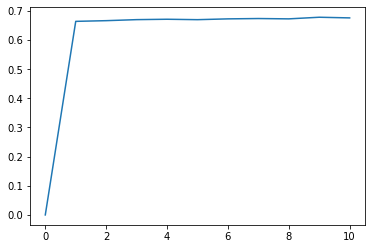

In [33]:
%matplotlib inline

#plt.figure()
plt.plot(epochs_val, all_val_dice, label='dice_val')
# plt.xlabel('epochs')
# plt.legend()
# plt.title('Dice score')
# plt.savefig(path + '/dice_val.png')
# plt.close()


In [34]:
# STUDENT TO DO 3.5.5 RELOAD AND TRAIN FROM *YOUR* SAVED MODEL
# BE SURE TO LOAD BOTH THE MODEL AND OPTIMISER STATE DICT
# PRINT OUT THE PARAMETERS OF THE OPTIMISER STATE DICT AFTER LOADING
for param_tensor in net.state_dict():
    print(param_tensor, "\t", net.state_dict()[param_tensor].size())

dconv_down1.0.weight 	 torch.Size([32, 1, 3, 3])
dconv_down1.0.bias 	 torch.Size([32])
dconv_down1.2.weight 	 torch.Size([32, 32, 3, 3])
dconv_down1.2.bias 	 torch.Size([32])
dconv_down2.0.weight 	 torch.Size([64, 32, 3, 3])
dconv_down2.0.bias 	 torch.Size([64])
dconv_down2.2.weight 	 torch.Size([64, 64, 3, 3])
dconv_down2.2.bias 	 torch.Size([64])
dconv_down3.0.weight 	 torch.Size([128, 64, 3, 3])
dconv_down3.0.bias 	 torch.Size([128])
dconv_down3.2.weight 	 torch.Size([128, 128, 3, 3])
dconv_down3.2.bias 	 torch.Size([128])
dconv_down4.0.weight 	 torch.Size([256, 128, 3, 3])
dconv_down4.0.bias 	 torch.Size([256])
dconv_down4.2.weight 	 torch.Size([256, 256, 3, 3])
dconv_down4.2.bias 	 torch.Size([256])
dconv_down5.0.weight 	 torch.Size([512, 256, 3, 3])
dconv_down5.0.bias 	 torch.Size([512])
dconv_down5.2.weight 	 torch.Size([512, 512, 3, 3])
dconv_down5.2.bias 	 torch.Size([512])
dconv_up4.0.weight 	 torch.Size([256, 768, 3, 3])
dconv_up4.0.bias 	 torch.Size([256])
dconv_up4.2.weigh

## **Results** 
the results are saved to a folder \results - so please check that:

The results are saved per epoch for both training and validation, and are saved as the 
1. real data, 
2. binary labels, 
3. predicted labels. 

In this example since we trained on a small sample of the data (100 crops) the results are far from optimal, and are likely to overfit to the data.

# Homework - Create your own U-net for brain segmentation

Also provided on KEATS is a folder of T2 weighted axial brain slices with tissue labels. An example of how to read them is given below.

TO DO: 

1. Build a bespoke Pytorch dataset for these examples. Remember to one hot encode the labels and convert to PyTorch tensors of the correct type and shape
2. Create separate DataLoaders for train and validation sets
3. create your own Unet to segment this data 
   - try replacing the maxpools above with strided convolutions
   - try replacing the dropout and instead including a batchnorm
4. train you network using the dice and cross entropy loss, report train and validation performance
5. optimise your network to get the best performance



In [35]:
import pandas as pd
import os
import matplotlib.pyplot as plt


# edit this path to match where you put your data
path_relative_to_drive='Colab Notebooks/Colab_Data/mrimages/'
data_path=path_relative_to_drive+'mridata/'

full_path=os.path.join('/content/drive/My Drive/', data_path)

# read in the labels for train test and val
# these are scv files with 2 labels for each image (age at birth and age at scan)
meta_train=pd.read_csv(os.path.join('/content/drive/My Drive/', path_relative_to_drive + 'data_train_AML.csv'))
meta_valid=pd.read_csv(os.path.join('/content/drive/My Drive/', path_relative_to_drive + 'data_valid_AML.csv'))

print('number of train samples', len(meta_train))
print('number of validation samples', len(meta_valid))



number of train samples 324
number of validation samples 32


/content/drive/My Drive/Colab Notebooks/Colab_Data/mrimages/mridata/1_t2w.npy


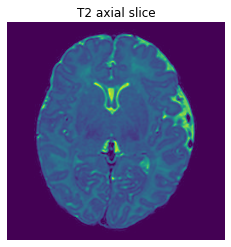

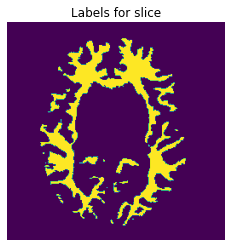

image shape (4, 256, 256) [0. 1.]


In [36]:
def load_data(fullpath, meta,idx):
  ''' example of how to load and normalise data '''
  image_path=os.path.join(full_path,meta['image_name'][idx])
  label_path=os.path.join(full_path,meta['label_name'][idx])
  print(image_path)

  image=np.load(image_path) 
  # the label file should be 
  label=np.load(label_path) 

  # normalise into range 0-1
  if np.max(image)-np.min(image) !=0:
    image=(image-np.min(image))/(np.max(image)-np.min(image))
 
  return image,label

example_im, example_lab=load_data(full_path, meta_train,0)

plt.imshow(example_im); plt.axis('off')
plt.title('T2 axial slice')
plt.show()

plt.imshow(example_lab[3]); plt.axis('off')
plt.title('Labels for slice')
plt.show()

print('image shape',example_lab.shape,np.unique(example_lab))

In [37]:
# STUDENT TO DO - CREATE BESPOKE DATASET
# REMEMBER TO CONVERT TO TORCH TENSORS of shape (C,H,W) AND ONE HOT ENCODE THE LABELS
LABELS_DICT = {0: 'background', 1: 'csf', 2: 'cortical gray matter', 3: 'white matter'}


class BrainSegmentationDataset(torch.utils.data.Dataset): 
    
    # initialise the class based on the folder containing the data and the project dataframe
    def __init__(self, folder='', meta='', transform=None): 
        
        # STUDENTS CODE - replace Nones with correct code #
       # 2.1.1 initialise the paths to the data folder, the data frame and define the transform operations
        self.folder = folder
        self.meta = meta
        self.transform=transform
        
    
    def __len__(self):
        # STUDENTS CODE - replace Nones with correct code #
         # 2.1.2 return the number of examples in the dataset
        return len(self.meta)
    
    def __getitem__(self, idx):
        
        # load images 
        image_path=os.path.join(self.folder,self.meta['image_name'][idx])
        label_path=os.path.join(self.folder,self.meta['label_name'][idx])

        image=np.load(image_path)
        #convert one hot encoded label to tensor
        label=torch.from_numpy(np.load(label_path)).to(torch.int64)


        if self.transform:
            # convert image to tensor and normalise
            img_tensor = self.transform(image)
        

        sample = img_tensor, label

        
            
        return sample

length 324


Text(0.5, 1.0, 'white matter')

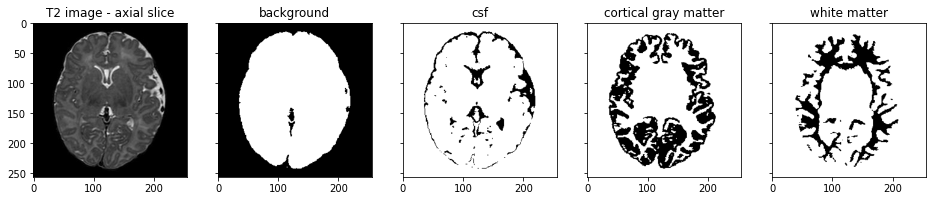

In [39]:
from torch.utils.data import DataLoader

# testing out the dataset class

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])

# Create an instance of the BrainSegmentationDataset class by calling the constructor
ds = BrainSegmentationDataset(full_path,meta_train,transform) # then we create the dataset 

#check that the length is correct
print('length',ds.__len__())

#return index 0 from getitem
example_im,ex_label=ds.__getitem__(0)

#. plot 

fig, ax = plt.subplots(ncols=5, sharex=True, sharey=True,
                       figsize=(16, 8))
ax[0].imshow(example_im[0,:,:], cmap=plt.cm.gray)
ax[0].set_title('T2 image - axial slice')
ax[1].imshow(ex_label[0,:,:], cmap=plt.cm.binary)
ax[1].set_title(LABELS_DICT[0])
ax[2].imshow(ex_label[1,:,:], cmap=plt.cm.binary)
ax[2].set_title(LABELS_DICT[1])
ax[3].imshow(ex_label[2,:,:], cmap=plt.cm.binary)
ax[3].set_title(LABELS_DICT[2])
ax[4].imshow(ex_label[3,:,:], cmap=plt.cm.binary)
ax[4].set_title( LABELS_DICT[3])


In [40]:
# STUDENT TO DO - CREATE SEPARATE DATA SETS and LOADERS FOR TRAIN AND VALIDATION

# train loader batch size 16
train_dataset = BrainSegmentationDataset(full_path,meta_train,transform) # then we create the dataset 
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle = True)

# validation loader batch size 32 (all validation images)
valid_dataset = BrainSegmentationDataset(full_path,meta_valid,transform) # then we create the dataset 
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = False)

im_batch, lab_batch = next(iter(train_loader)) # get a batch
print('batch shape', im_batch.shape) 

batch shape torch.Size([16, 1, 256, 256])


In [41]:
# STUDENT TO DO - CREATE UNET
# TRY STRUDED CONVOLUTIONS AND BATHNORM INSTEAD OF DROPOUT

# define U-net double conv with striding
def double_conv(in_channels, out_channels, s=1, padding=1):
    ''' adding s=stride '''
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=padding),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=padding),
        nn.ReLU(inplace=True)
    )


class UNet2(nn.Module):

    def __init__(self):
        super().__init__()
        
        self.dconv_down1 = double_conv(1, 8)
        self.strided_conv1=nn.Conv2d(8, 8, stride=2,kernel_size=3, padding=1)
        self.dconv_down2 = double_conv(8, 16)
        self.strided_conv2=nn.Conv2d(16, 16, stride=2,kernel_size=3, padding=1)
        self.dconv_down3 = double_conv(16, 32)
        self.strided_conv3=nn.Conv2d(32, 32, stride=2,kernel_size=3, padding=1)
        self.dconv_down4 = double_conv(32, 64)
        self.strided_conv4=nn.Conv2d(64, 64, stride=2,kernel_size=3, padding=1)
        self.dconv_down5 = double_conv(64, 128)

        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear')
        self.dconv_up4 = double_conv(64 + 128, 64)
        self.dconv_up3 = double_conv(32 + 64, 32)
        self.dconv_up2 = double_conv(16 + 32, 16)
        self.dconv_up1 = double_conv(8 + 16, 8)

        self.conv_last = nn.Conv2d(8, 4, 1)

    def forward(self, x):
        
        #######   ENCODER ###############
        
        conv1 = self.dconv_down1(x)
        x = self.strided_conv1(conv1)
        conv2 = self.dconv_down2(x)
        x = self.strided_conv2(conv2)
        conv3 = self.dconv_down3(x)
        x = self.strided_conv3(conv3)
        conv4 = self.dconv_down4(x)
        x = self.strided_conv4(conv4)

        # bottleneck 
        conv5 = self.dconv_down5(x)
        #######   DECODER ###############
        deconv4 = self.upsample(conv5)
        deconv4 = torch.cat([deconv4, conv4], dim=1)
        deconv4  = self.dconv_up4(deconv4)

        deconv3 = self.upsample(deconv4)
        deconv3 = torch.cat([deconv3, conv3], dim=1)
        deconv3  = self.dconv_up3(deconv3)
        deconv2 = self.upsample(deconv3)
        deconv2 = torch.cat([deconv2, conv2], dim=1)
        deconv2  = self.dconv_up2(deconv2)
 
        deconv1 = self.upsample(deconv2)
        deconv1 = torch.cat([deconv1, conv1], dim=1)
        deconv1  = self.dconv_up1(deconv1)

        return F.softmax(self.conv_last(deconv1),dim=1) # need softmax for dice calculation (hard threshold on labels)


In [42]:
# STUDENT TO DO - CHOOSE SUITABLE LOSS AND OPTIMISER
import torch.optim as optim

my_unet = UNet2()
my_unet = my_unet.to(device) 

# implementing adam optimiser
optimizer = optim.Adam(my_unet.parameters(), lr=0.001)

In [43]:
# using dice loss from   https://github.com/kevinzakka/pytorch-goodies/blob/master/losses.py

def dice_coeff(pred, target):
   

    epsilon = 10e-8
    dims = (0,) + tuple(range(2, target.ndimension()))
    intersection = torch.sum(pred * target, dims)
    cardinality = torch.sum(pred + target, dims)
    
    dice = (2. * intersection / (cardinality + epsilon))
    dice_loss=dice.mean()

    return dice_loss

    


In [44]:
epochs=20
mean_train_dice=[]
mean_val_dice=[]

for epoch in range(epochs):

    ##########
    # Train
    ##########
    
    my_unet.train() 
    train_dice= []

    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label= label.to(device)

        optimizer.zero_grad() 

        pred = my_unet(data)
        # just training with cross entropy for now
        err = 1- dice_coeff(pred, label) 
        # -------------------------------------------------------------------------------------------------------------------

        err.backward()
        optimizer.step()
        
        dice_value=dice_coeff(pred, label).item()

        pred_detached=pred[1,2,:,:].data.cpu().numpy()
        
        print('[{:d}/{:d}][{:d}/{:d}] Dice: {:.4f} '
              .format(epoch, epochs, i, len(train_loader), dice_value))

        
        
        train_dice.append(dice_value)
      

    # #############
    # # Validation
    # #############
    
    # set network to eval prior to training loop 
    my_unet.eval()
    val_dice= []
    for i, (data, label) in enumerate(valid_loader):
        data=data.to(device)
        label=label.to(device)     

        pred = my_unet(data)
        
        err = 1-dice_coeff(pred, label) 
       
        val_dice.append(dice_coeff(pred, label).item())

        
    mean_val_dice.append(np.mean(val_dice))
    mean_train_dice.append(np.mean(train_dice))

   

    print('Val Dice: {}, Train Dice: {:.4f}'.format(np.mean(mean_val_dice),np.mean(train_dice)))
    


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


[0/20][0/21] Dice: 0.2119 
[0/20][1/21] Dice: 0.2121 
[0/20][2/21] Dice: 0.2086 
[0/20][3/21] Dice: 0.2130 
[0/20][4/21] Dice: 0.2145 
[0/20][5/21] Dice: 0.2163 
[0/20][6/21] Dice: 0.2172 
[0/20][7/21] Dice: 0.2229 
[0/20][8/21] Dice: 0.2248 
[0/20][9/21] Dice: 0.2367 
[0/20][10/21] Dice: 0.2026 
[0/20][11/21] Dice: 0.2465 
[0/20][12/21] Dice: 0.2448 
[0/20][13/21] Dice: 0.2432 
[0/20][14/21] Dice: 0.2471 
[0/20][15/21] Dice: 0.2543 
[0/20][16/21] Dice: 0.2620 
[0/20][17/21] Dice: 0.2680 
[0/20][18/21] Dice: 0.2723 
[0/20][19/21] Dice: 0.2784 
[0/20][20/21] Dice: 0.2789 
Val Dice: 0.2871161699295044, Train Dice: 0.2370
[1/20][0/21] Dice: 0.2873 
[1/20][1/21] Dice: 0.2899 
[1/20][2/21] Dice: 0.2949 
[1/20][3/21] Dice: 0.2965 
[1/20][4/21] Dice: 0.3028 
[1/20][5/21] Dice: 0.3101 
[1/20][6/21] Dice: 0.3119 
[1/20][7/21] Dice: 0.3215 
[1/20][8/21] Dice: 0.3334 
[1/20][9/21] Dice: 0.3292 
[1/20][10/21] Dice: 0.3233 
[1/20][11/21] Dice: 0.3219 
[1/20][12/21] Dice: 0.3398 
[1/20][13/21] Dice:

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


0 (1, 4, 256, 256) (1, 4, 256, 256) 65536 43960.0


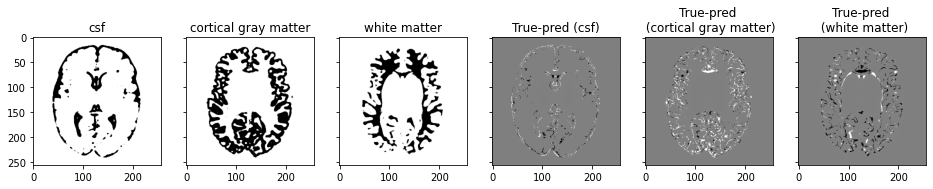

1 (1, 4, 256, 256) (1, 4, 256, 256) 65536 42019.0


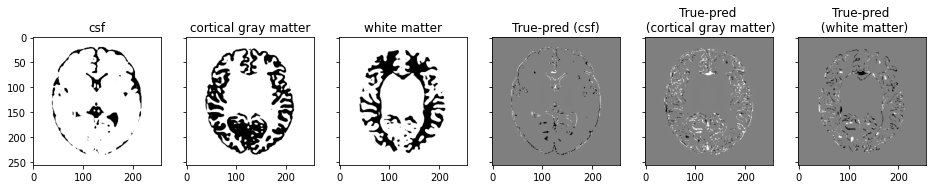

2 (1, 4, 256, 256) (1, 4, 256, 256) 65536 47315.0


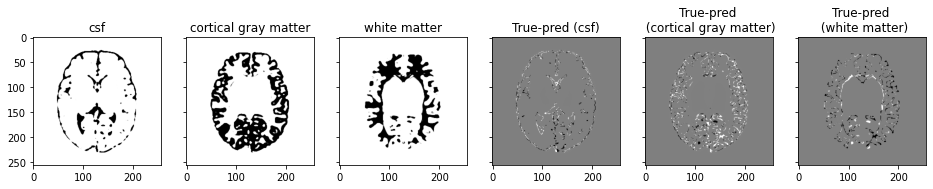

3 (1, 4, 256, 256) (1, 4, 256, 256) 65536 44423.0


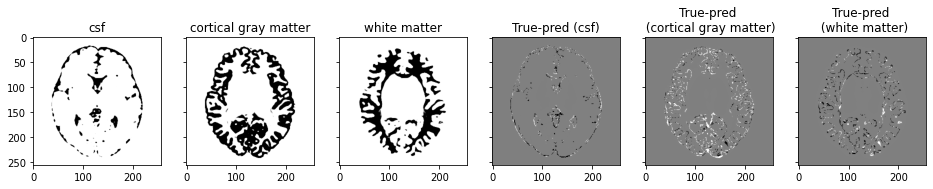

4 (1, 4, 256, 256) (1, 4, 256, 256) 65536 45859.0


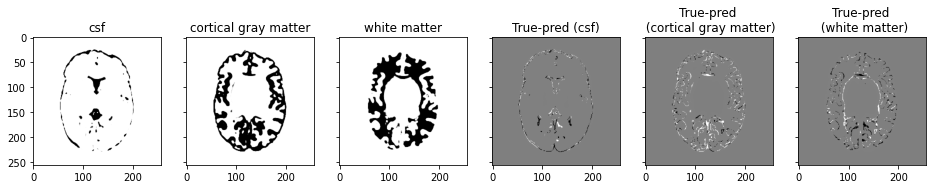

In [45]:
# plot all va;idation predictions against ground truth 
valid_loader = DataLoader(valid_dataset, batch_size = 1, shuffle = False)

# set network to eval prior to training loop 
my_unet.eval()
val_dice= []
for i, (data, label) in enumerate(valid_loader):
    data=data.to(device)
    label=label.to(device)     

    pred = my_unet(data)
    
    DICE= dice_coeff(pred, label) 

    y_true = label.data.cpu().numpy()
    y_pred = pred.data.cpu().numpy()

    print(i,y_true.shape,y_pred.shape,y_pred.shape[2]*y_pred.shape[3], np.sum(y_pred[y_pred==1]))
    

    fig, ax = plt.subplots(ncols=6, sharex=True, sharey=True,
                       figsize=(16, 8))
    ax[0].imshow(y_pred[0,1,:,:], cmap=plt.cm.binary)
    ax[0].set_title(LABELS_DICT[1])
    ax[1].imshow(y_pred[0,2,:,:], cmap=plt.cm.binary)
    ax[1].set_title(LABELS_DICT[2])
    ax[2].imshow(y_pred[0,3,:,:], cmap=plt.cm.binary)
    ax[2].set_title( LABELS_DICT[3])
    ax[3].imshow(y_true[0,1,:,:]-y_pred[0,1,:,:], cmap=plt.cm.binary)
    ax[3].set_title('True-pred (' + LABELS_DICT[1] +')')
    ax[4].imshow(y_true[0,2,:,:]-y_pred[0,2,:,:], cmap=plt.cm.binary)
    ax[4].set_title('True-pred \n (' + LABELS_DICT[2] +')')
    ax[5].imshow(y_true[0,3,:,:]-y_pred[0,3,:,:], cmap=plt.cm.binary)
    ax[5].set_title( 'True-pred \n (' + LABELS_DICT[3] +')')
    plt.show()

    if i> 3:
      break

    